In [1]:
library(NormqPCR)
library(pheatmap)
library(readxl)
library(plotrix)

Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: ReadqPCR

Loading required package: qpcR

Loading required package: MASS

Loadi

In [2]:
######################################## 
### FUNCTION FOR RLE-PLOT AND RUV_total
########################################

RLEplot_mod <- function(data,pdata_group){
  
Color_Batches <- c('purple','orange','brown','blue','darkgreen','pink','gray','red','black','green','navy','Violet')
par(mar = c(6.5,6.5,2.3,0))
boxplot(data - rowMedians(data), main = '', xlab ='', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1,4.1),xlim=c(0,50),
        outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
        staplelwd = 0 , boxcol = Color_Batches[factor(pdata_group)],
        border = Color_Batches[factor(pdata_group)], col = 'gray87')
box(lwd = 7, bty = 'l')
title('RLE plot', line = -2, cex.main = 3.5)
Median_Nano <- apply(data - rowMedians(data), 2, median)
points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
axis(2, mgp = c(3.5, .9 ,0), lwd.ticks=6, las=1, cex.axis=3)
mtext('RLE', 2, line = 3.5, cex = 3.5)
abline(h = 0, col = 'black', lwd = 5, lty = 2)
par(lwd = 3)
axis.break(2, -4.2, style = 'zigzag', brw = .02)
x_labs <- levels(factor(colnames(data)))

text(x = seq_along(x_labs), y = -4.5, labels = x_labs, 
     srt = 90,    # rotate
     adj = 1,    # justify
     xpd = TRUE)    # plot in margin

legend(36, 4.1, legend = unique(factor(pdata_group)),
       col = unique(Color_Batches[factor(pdata_group)]),
       pch = 15, bty = 'n', cex = 1)
text(x = 40, y = 4.2 ,labels  = 'Run', cex = 1.5)

}

In [3]:
##### FUNCTION FOR RUVg  ### Bhattacharia et. al. 

RUV_total <- function(raw,pData,fData,k,hkgenes = NULL,exclude = NULL){
  
  library(RUVSeq)
  library(DESeq2)
  library(limma)
  library(matrixStats)
  
  if (!is.null(hkgenes)){
    
    fData(set)$CodeClass[rownames(set) %in% hkgenes] = 'Housekeeping'
    
  }
  
  
  fData = fData[rownames(raw),]
  int = intersect(rownames(raw),rownames(fData))
  fData = fData[int,]
  raw = raw[int,]
  
  set <- newSeqExpressionSet(as.matrix(round(raw)),
                             phenoData=pData,
                             featureData=fData)
  
  cIdx <- rownames(set)[fData(set)$`Class Name` == "Housekeeping"]
  cIdx = cIdx[!(cIdx %in% exclude)]
  x <- as.factor(pData$Group)
  set <- betweenLaneNormalization(set, which="upper")
  set <- RUVg(set, cIdx, k=k)
  dds <- DESeqDataSetFromMatrix(counts(set),colData=pData(set),design=~1)
  rowData(dds) <- fData
  dds <- estimateSizeFactors(dds)
  dds <- estimateDispersionsGeneEst(dds)
  cts <- counts(dds, normalized=TRUE)
  disp <- pmax((rowVars(cts) - rowMeans(cts)),0)/rowMeans(cts)^2
  mcols(dds)$dispGeneEst <- disp
  dds <- estimateDispersionsFit(dds, fitType="mean")
  vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
  mat <- assay(vsd)
  covars <- as.matrix(colData(dds)[,grep("W",colnames(colData(dds))),drop=FALSE])
#   mat_has_na = count(is.na(mat))
#   covar_has_na = count(is.na(covars))
#   if (mat_has_na > 0) {
#       print('mat has na values')
#   }
#   if (covar_has_na > 0) {
#       print('covar has na values')
#       print(covars)
#   }
  
  mat <- removeBatchEffect(mat, covariates=covars)
  assay(vsd) <- mat
  return(list(set = set,vsd = vsd))
  
}

In [4]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [5]:
raw = read.csv('Data/raw_count_transponsed_raw.csv', row.names = 1, check.names = F )
norm_count = read.csv('Data/raw_count.csv', row.names = 1, check.names = F)
# sample annotations:
# annot = read.csv('Data/annot_3.csv', row.names = 1, check.names = F )
annot = read.csv('Data/annot_clinical.csv', row.names = 1, check.names = F )
# annot = read.csv('Data/annot_clinical_2.csv', row.names = 1, check.names = F )

# gene annotations:
gannot = read.csv('Data/gannot_raw.csv', row.names = 1, check.names = F )
old_gannot=read.csv('Data/gannot.csv', row.names = 1, check.names = F)
clin = read.csv('Data/annot.csv', row.names = 1, check.names = F )

### Data overview



In [6]:
raw_expression <- raw
print(dim(raw_expression))
raw_expression

[1] 784  48


,20230616_210462891024_K1241-B_02.RCC,20230616_210462891024_K1628-B_03.RCC,20230616_210462891024_K1865-B_04.RCC,20230616_210462891024_K2032-B_05.RCC,20230616_210462891024_K2068-B_06.RCC,20230616_210462891024_K2323-B_07.RCC,20230616_210462891024_K2360-B_08.RCC,20230616_210462891024_K2520-B_09.RCC,20230616_210462891024_K2669-B_10.RCC,20230616_210462891024_K2742-B_11.RCC,⋯,20230707_210462901024_K2894-Tx_03.RCC,20230707_210462901024_K2917-Tx_04.RCC,20230707_210462901024_K3056-Tx_05.RCC,20230707_210462901024_K3566-Tx_06.RCC,20230707_210462901024_K3953-Tx_07.RCC,20230707_210462901024_K3975-Tx_08.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462901024_K4368-Tx_12.RCC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A2M,45,20742,5264,4893,16547,3730,5259,1057,4189,600,⋯,463,2773,2173,1316,304,620,2356,724,514,25105
ABCB1,6,161,28,46,12,42,10,105,76,21,⋯,36,32,26,31,15,16,94,9,5,25
ABL1,16,1557,164,707,621,1082,286,466,1448,508,⋯,60,123,308,50,477,291,182,287,186,830
ADA,12,70,31,78,67,199,58,56,229,70,⋯,43,14,113,10,15,29,53,58,36,69
ADORA2A,3,27,40,24,26,36,58,24,47,14,⋯,24,8,54,9,7,9,28,19,20,46
AICDA,7,10,8,11,8,14,11,7,31,12,⋯,4,9,6,5,37,7,8,12,8,11
AIRE,12,10,12,20,13,23,15,58,22,21,⋯,33,13,27,10,10,10,16,14,12,18
AKT3,64,4438,392,228,2078,1230,831,2316,5802,60,⋯,696,258,123,112,31,212,2060,126,283,3283
ALCAM,12,1637,205,155,261,333,28,98,8166,9,⋯,67,169,86,41,80,112,427,21,49,617


In [7]:
fData=gannot
head(fData)

,Class Name,% Samples above Threshold,Immune Response Category,Accession,Common Name,Gene_Class
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
A2M,Endogenous,100,Chemokines,NM_000014.4,A2M,Immune Response
ABCB1,Endogenous,100,,NM_000927.3,ABCB1,Immune Response
ABCF1,Housekeeping,100,,NM_001090.2,ABCF1,HK
ABL1,Endogenous,100,"Cell Cycle, Regulation, Senescence",NM_005157.3,ABL,Immune Response
ADA,Endogenous,100,"B-Cell Functions, T-Cell Functions",NM_000022.2,ADA,Immune Response
ADORA2A,Endogenous,100,Cell Functions,NM_000675.3,ADORA2A,Immune Response - Checkpoint


In [8]:
pData <- annot
pData

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230707_210462871024_K1241-Tx_09.RCC,Soft Tissue Sarcoma,Treatment,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230707_210462871024_K1628-Tx_10.RCC,Soft Tissue Sarcoma,Treatment,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230707_210462871024_K2032-Tx_11.RCC,Soft Tissue Sarcoma,Treatment,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS


#### Data filering

In [9]:
fData$IsControl = fData$`Class Name`!='Endogenous'
l1 = row.names(fData[fData$`Class Name`=='Negative',])
l2 = row.names(fData[fData$`Class Name`=='Positive',])
exclude= c(l1, l2)

In [10]:
cIdx <- rownames(raw_expression)
cIdx = cIdx[!(cIdx %in% exclude)]

In [11]:
raw_expression_ex = raw_expression[cIdx,]
print(dim(raw_expression_ex))
raw_expression_ex

[1] 770  48


,20230616_210462891024_K1241-B_02.RCC,20230616_210462891024_K1628-B_03.RCC,20230616_210462891024_K1865-B_04.RCC,20230616_210462891024_K2032-B_05.RCC,20230616_210462891024_K2068-B_06.RCC,20230616_210462891024_K2323-B_07.RCC,20230616_210462891024_K2360-B_08.RCC,20230616_210462891024_K2520-B_09.RCC,20230616_210462891024_K2669-B_10.RCC,20230616_210462891024_K2742-B_11.RCC,⋯,20230707_210462901024_K2894-Tx_03.RCC,20230707_210462901024_K2917-Tx_04.RCC,20230707_210462901024_K3056-Tx_05.RCC,20230707_210462901024_K3566-Tx_06.RCC,20230707_210462901024_K3953-Tx_07.RCC,20230707_210462901024_K3975-Tx_08.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462901024_K4368-Tx_12.RCC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A2M,45,20742,5264,4893,16547,3730,5259,1057,4189,600,⋯,463,2773,2173,1316,304,620,2356,724,514,25105
ABCB1,6,161,28,46,12,42,10,105,76,21,⋯,36,32,26,31,15,16,94,9,5,25
ABL1,16,1557,164,707,621,1082,286,466,1448,508,⋯,60,123,308,50,477,291,182,287,186,830
ADA,12,70,31,78,67,199,58,56,229,70,⋯,43,14,113,10,15,29,53,58,36,69
ADORA2A,3,27,40,24,26,36,58,24,47,14,⋯,24,8,54,9,7,9,28,19,20,46
AICDA,7,10,8,11,8,14,11,7,31,12,⋯,4,9,6,5,37,7,8,12,8,11
AIRE,12,10,12,20,13,23,15,58,22,21,⋯,33,13,27,10,10,10,16,14,12,18
AKT3,64,4438,392,228,2078,1230,831,2316,5802,60,⋯,696,258,123,112,31,212,2060,126,283,3283
ALCAM,12,1637,205,155,261,333,28,98,8166,9,⋯,67,169,86,41,80,112,427,21,49,617


In [12]:
pData <- annot[colnames(raw_expression_ex),]
pData

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS


In [13]:
fData_ex = fData

In [14]:
k = 1  
vsd = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$set # ,exclude = exc

Loading required package: EDASeq

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicRanges

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The followi

In [15]:
normalizedcount <- set@assayData[["normalizedCounts"]]
normalizedcount

,20230616_210462891024_K1241-B_02.RCC,20230616_210462891024_K1628-B_03.RCC,20230616_210462891024_K1865-B_04.RCC,20230616_210462891024_K2032-B_05.RCC,20230616_210462891024_K2068-B_06.RCC,20230616_210462891024_K2323-B_07.RCC,20230616_210462891024_K2360-B_08.RCC,20230616_210462891024_K2520-B_09.RCC,20230616_210462891024_K2669-B_10.RCC,20230616_210462891024_K2742-B_11.RCC,⋯,20230707_210462901024_K2894-Tx_03.RCC,20230707_210462901024_K2917-Tx_04.RCC,20230707_210462901024_K3056-Tx_05.RCC,20230707_210462901024_K3566-Tx_06.RCC,20230707_210462901024_K3953-Tx_07.RCC,20230707_210462901024_K3975-Tx_08.RCC,20230707_210462901024_K4106-Tx_09.RCC,20230707_210462901024_K4258-Tx_10.RCC,20230707_210462901024_K4360-Tx_11.RCC,20230707_210462901024_K4368-Tx_12.RCC
A2M,974,21125,8326,5337,15482,2073,10973,1842,1848,1970,⋯,2034,13405,2376,7643,1065,1757,2867,2023,1697,19457
ABCB1,125,150,56,44,12,28,20,146,28,48,⋯,137,161,33,232,52,47,128,26,18,18
ABL1,313,1232,490,547,634,1005,546,439,408,621,⋯,176,661,508,574,1659,937,301,948,767,534
ADA,248,64,66,73,65,139,116,74,83,148,⋯,158,71,148,79,52,87,74,175,131,50
ADORA2A,63,25,74,24,25,22,119,36,18,36,⋯,95,40,65,62,24,27,36,55,70,34
AICDA,144,8,17,10,8,10,22,9,11,23,⋯,15,46,8,42,129,22,12,36,29,8
AIRE,237,8,34,16,13,21,28,58,6,28,⋯,100,69,43,109,35,31,25,45,48,12
AKT3,1338,4149,768,222,2002,813,1682,3277,2198,140,⋯,2668,1292,155,819,108,628,2782,372,1007,2389
ALCAM,261,1691,313,172,243,180,59,177,3694,32,⋯,301,812,92,229,281,315,511,58,159,484
AMBP,84,3,12,7,10,7,18,10,3,26,⋯,42,10,9,30,28,12,12562,15,18,6


In [39]:
library(plotrix)
library(ggplot2)
library("pheatmap")
library(EnhancedVolcano)
library('tidyr')

Loading required package: ggrepel


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [19]:
pData(set)

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.034331180
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.085521945
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA,-0.214989634
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.116582529
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS,-0.029203470
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS,-0.173686293
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.030520175
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.208871077
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.152098738


In [23]:
selected_coldata_baseline  <- subset(pData(set), Diagnosis == ' Baseline')
selected_coldata_baseline

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.03433118
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.08552195
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA,-0.21498963
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.11658253
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS,-0.02920347
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS,-0.17368629
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.03052018
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.20887108
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.15209874


In [24]:
subset_count_data_baseline = counts(set)[, row.names(selected_coldata_baseline)]


In [25]:
dds1 <- DESeqDataSetFromMatrix(countData = subset_count_data_baseline,
                              colData = selected_coldata_baseline,
                              design = ~ W_1 + RECIST_response )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [26]:
de_dds1 <- DESeq(dds1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [28]:
res_valcanoplot1 <- results(de_dds1)

In [32]:
firstC <- 'PD'
SecondC <- 'SD'
contrast<- c("RECIST_response",firstC,SecondC)
res_deseq1 <- as.data.frame(results(de_dds1))
nam1 <- paste('up_in',firstC, sep = '_')

In [33]:
res_deseq1[, nam1] <- as.logical(res_deseq1$log2FoldChange > 0)

res_deseq1$threshold <- as.logical(res_deseq1$padj < 0.05) 
res_deseq1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,5885.243315,-1.22729570,0.5708526,-2.14993441,3.156040e-02,0.1061201327,FALSE,FALSE
ABCB1,69.363693,-1.09062537,0.5434908,-2.00670448,4.478114e-02,0.1336491345,FALSE,FALSE
ABL1,589.613028,-0.24770458,0.3115831,-0.79498719,4.266210e-01,0.5929569218,FALSE,FALSE
ADA,92.502513,-0.64477124,0.2659730,-2.42419806,1.534224e-02,0.0690849197,FALSE,FALSE
ADORA2A,33.116023,0.53636289,0.2525534,2.12376033,3.369019e-02,0.1108608806,TRUE,FALSE
AICDA,18.091621,1.61267871,0.3266400,4.93717511,7.926230e-07,0.0001220639,TRUE,TRUE
AIRE,24.084696,0.34209664,0.3220816,1.06214270,2.881709e-01,0.4645557809,TRUE,FALSE
AKT3,1055.050251,0.03246428,0.4098613,0.07920798,9.368672e-01,0.9748483024,TRUE,FALSE
ALCAM,369.817612,0.45735580,0.5247757,0.87152631,3.834668e-01,0.5519055566,TRUE,FALSE


In [34]:
norm_mean_w1 <- sapply(levels(de_dds1$RECIST_response), function(lvl) rowMeans( counts(de_dds1,normalized=TRUE)[,de_dds1$RECIST_response == lvl, drop=F] ) )


In [35]:
colnames(norm_mean_w1) <- paste('Rowmean_exp_',levels(de_dds1$RECIST_response),sep='')

res1 <- cbind(norm_mean_w1,res_deseq1)
res1

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,7502.636342,3324.37102,5885.243315,-1.22729570,0.5708526,-2.14993441,3.156040e-02,0.1061201327,FALSE,FALSE
ABCB1,88.463121,39.12293,69.363693,-1.09062537,0.5434908,-2.00670448,4.478114e-02,0.1336491345,FALSE,FALSE
ABL1,596.313172,579.00447,589.613028,-0.24770458,0.3115831,-0.79498719,4.266210e-01,0.5929569218,FALSE,FALSE
ADA,105.820264,71.41607,92.502513,-0.64477124,0.2659730,-2.42419806,1.534224e-02,0.0690849197,FALSE,FALSE
ADORA2A,28.698713,40.11010,33.116023,0.53636289,0.2525534,2.12376033,3.369019e-02,0.1108608806,TRUE,FALSE
AICDA,9.647421,31.46160,18.091621,1.61267871,0.3266400,4.93717511,7.926230e-07,0.0001220639,TRUE,TRUE
AIRE,21.065401,28.86525,24.084696,0.34209664,0.3220816,1.06214270,2.881709e-01,0.4645557809,TRUE,FALSE
AKT3,1062.491995,1043.26749,1055.050251,0.03246428,0.4098613,0.07920798,9.368672e-01,0.9748483024,TRUE,FALSE
ALCAM,305.051868,472.36337,369.817612,0.45735580,0.5247757,0.87152631,3.834668e-01,0.5519055566,TRUE,FALSE


In [36]:
top_de_genes1 = res1[row.names(res_deseq1)[which(res_deseq1$threshold)],]
top_de_genes1

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
AICDA,9.647421,31.46160,18.091621,1.6126787,0.3266400,4.937175,7.926230e-07,0.0001220639,TRUE,TRUE
AMBP,6.463292,14.74221,9.668036,0.9630042,0.2698645,3.568473,3.590680e-04,0.0066428639,TRUE,TRUE
ATG10,112.889097,85.39645,102.246782,-0.5295003,0.1754284,-3.018327,2.541741e-03,0.0199708193,FALSE,TRUE
BID,12.985787,26.98587,18.405173,0.8554059,0.2149767,3.979064,6.918725e-05,0.0023162688,TRUE,TRUE
BLK,4.570318,11.07392,7.087843,1.1925712,0.3944116,3.023672,2.497272e-03,0.0198590457,TRUE,TRUE
BMI1,316.716980,224.48680,281.014977,-0.6455646,0.2051833,-3.146283,1.653600e-03,0.0151740059,FALSE,TRUE
C3,446.545656,153.24606,333.010328,-1.5359607,0.4733508,-3.244867,1.175054e-03,0.0131129163,FALSE,TRUE
C6,17.164096,29.30018,21.861936,0.7879400,0.2557453,3.080956,2.063369e-03,0.0178516198,TRUE,TRUE
C8A,9.123435,15.56922,11.618576,0.6765194,0.2481107,2.726683,6.397438e-03,0.0370378002,TRUE,TRUE


In [41]:
res_valcanoplot1 <- results(de_dds1)
res_valcanoplot1

log2 fold change (MLE): RECIST response SD vs PD 
Wald test p-value: RECIST response SD vs PD 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat      pvalue       padj
        <numeric>      <numeric> <numeric> <numeric>   <numeric>  <numeric>
A2M     5885.2433      -1.227296  0.570853 -2.149934   0.0315604  0.1061201
ABCB1     69.3637      -1.090625  0.543491 -2.006704   0.0447811  0.1336491
ABL1     589.6130      -0.247705  0.311583 -0.794987   0.4266210  0.5929569
ADA       92.5025      -0.644771  0.265973 -2.424198   0.0153422  0.0690849
ADORA2A   33.1160       0.536363  0.252553  2.123760   0.0336902  0.1108609
...           ...            ...       ...       ...         ...        ...
USP39    114.5145      -0.766351  0.215247 -3.560338 0.000370378 0.00664286
ZC3H14   435.7621      -0.471733  0.168889 -2.793154 0.005219682 0.03294389
ZKSCAN5   65.1884       0.163059  0.170799  0.954685 0.339737193 0.51095876
ZNF143   105.7946      -0.10544

In [37]:
write.csv(top_de_genes1, '10_DE_genes_PD_vs_SD_baseline_only.csv')

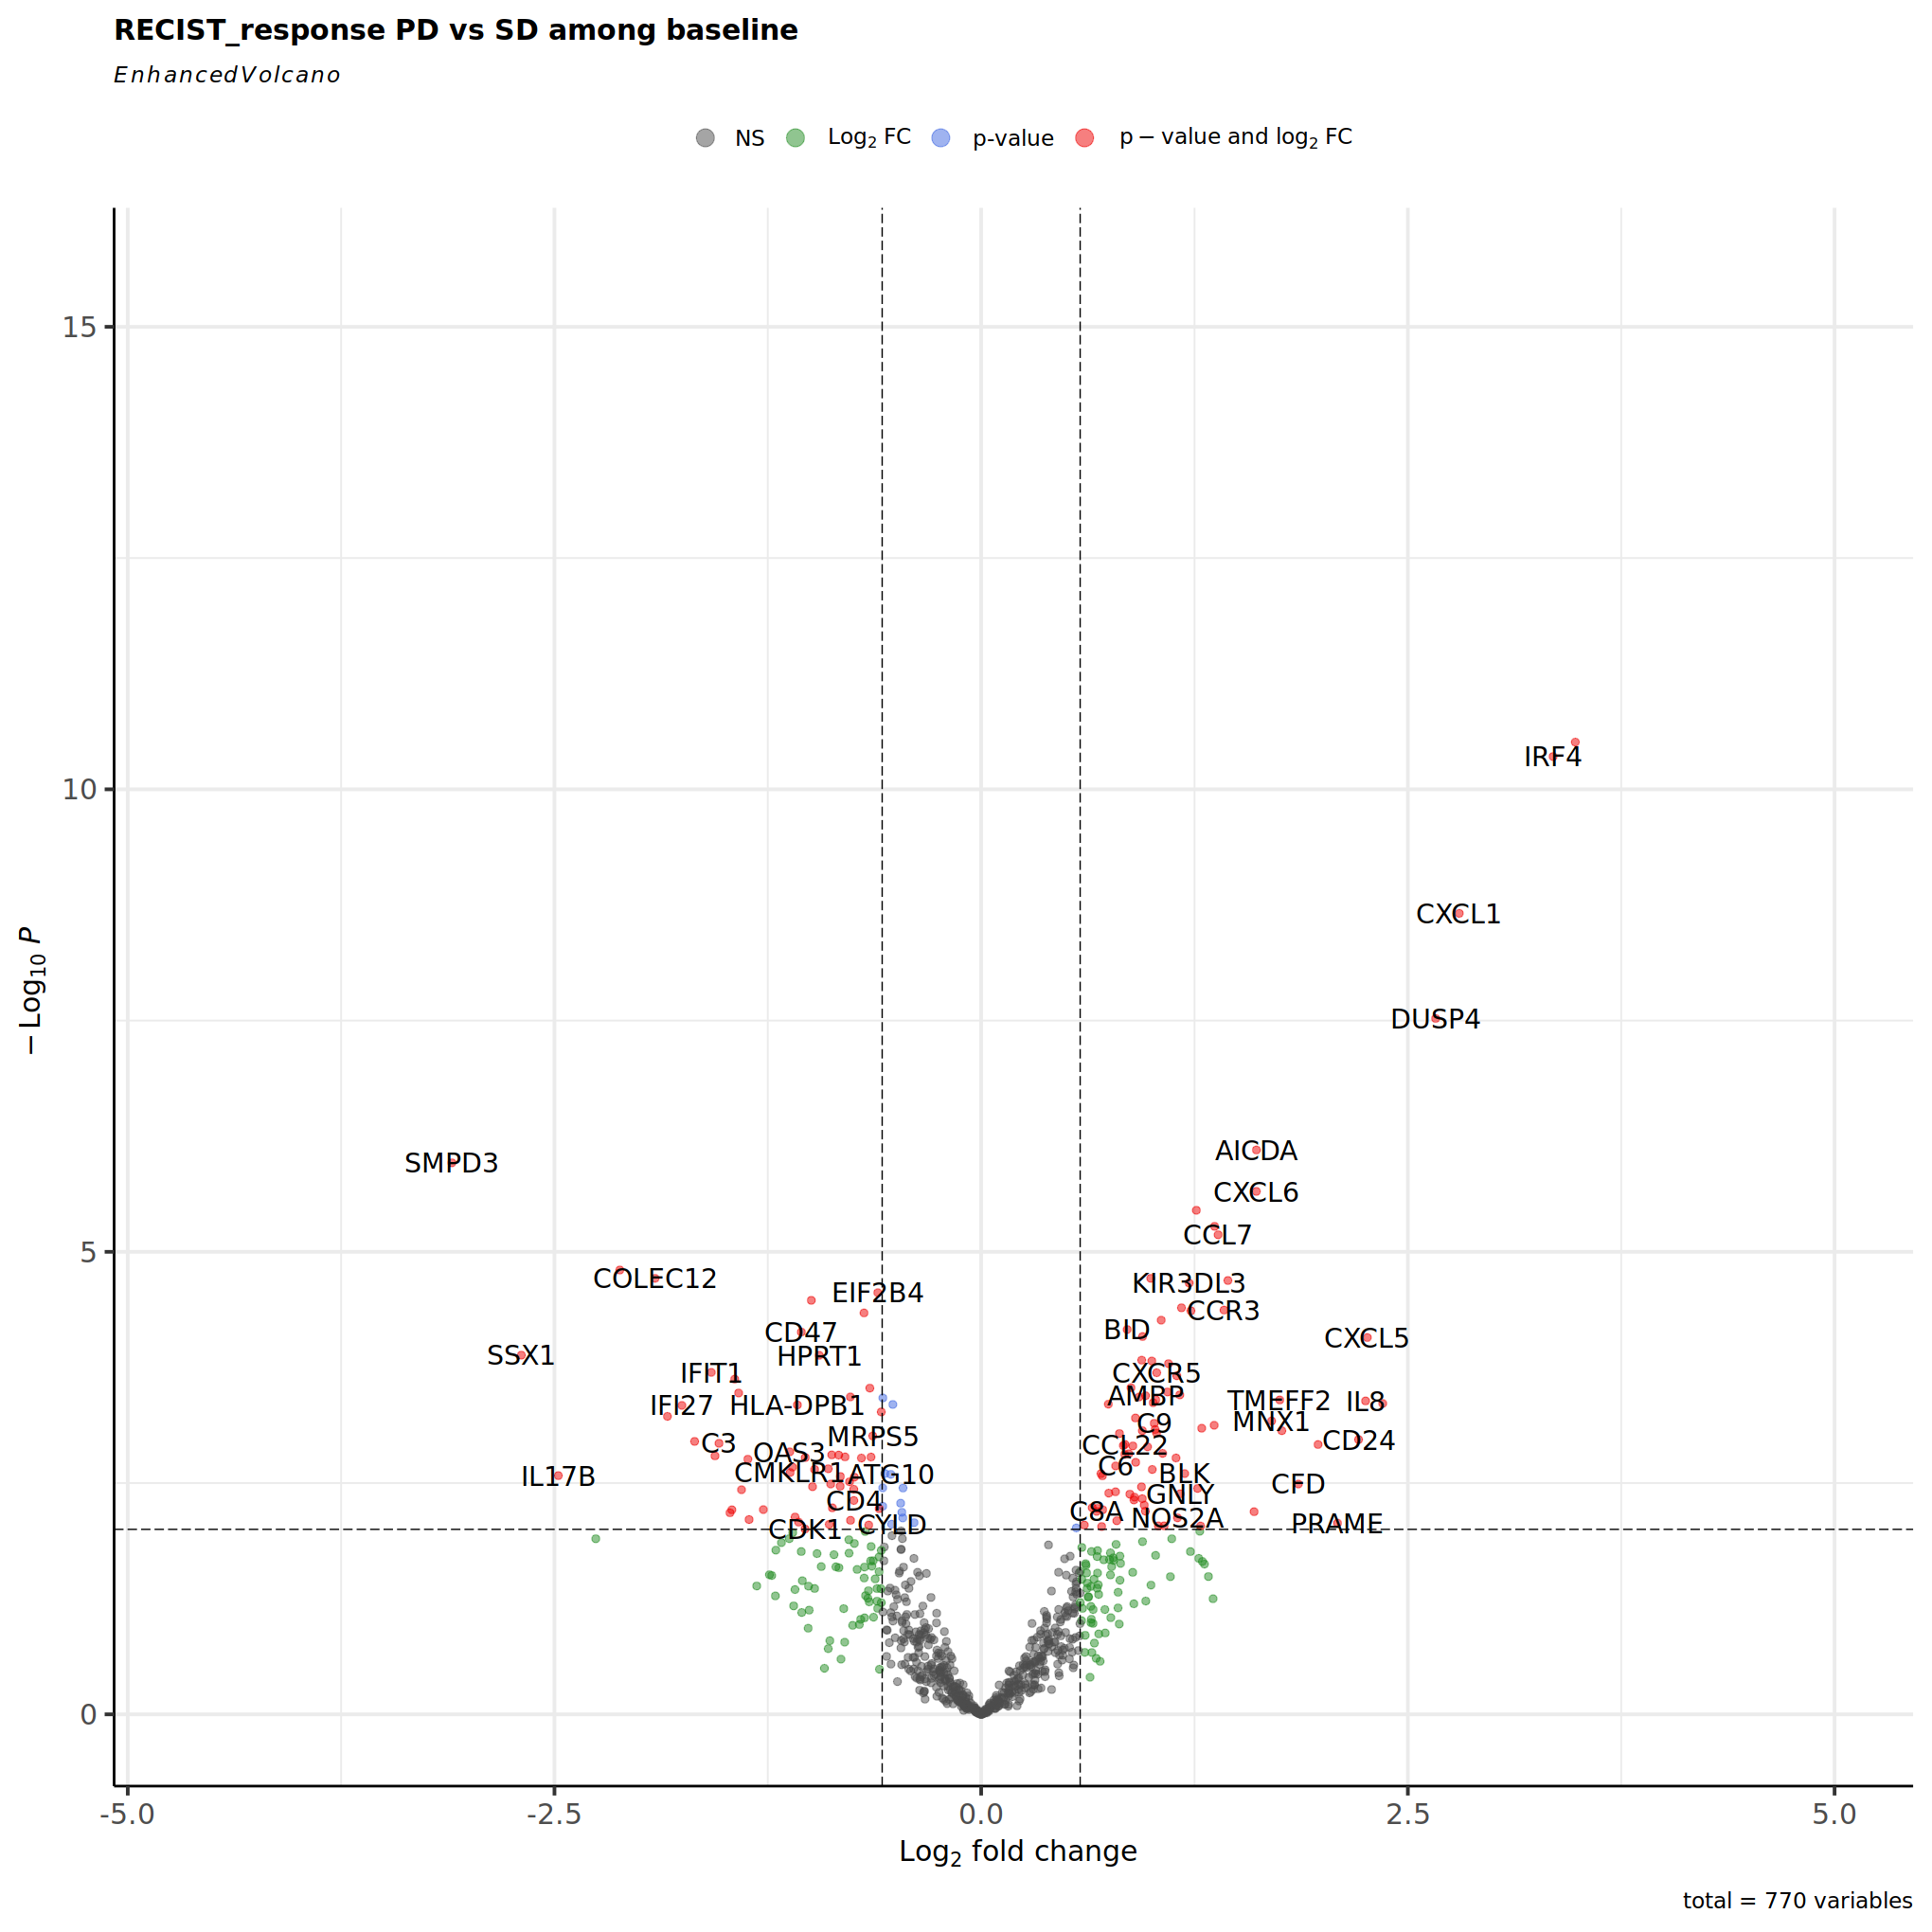

In [42]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# pdf('06_Baseline_vs_Treatment_volcano_plot_matched_id.pdf')
sdvspd_volplot1 <- EnhancedVolcano(res_valcanoplot1,
                lab = rownames(res_valcanoplot5), selectLab = row.names(top_de_genes1),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'RECIST_response PD vs SD among baseline',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)
# dev.off()
sdvspd_volplot1

In [43]:
ggsave("10_PD_vs_SD_volcano_plot_matched_id_baseline_only.pdf", 
       width = 10,
       height = 10, sdvspd_volplot1)



In [45]:
sorted_top_de1 = top_de_genes1[order(top_de_genes1$up_in_PD==TRUE, top_de_genes1$padj),]

In [46]:
col_labels1 = as.data.frame(colData(de_dds1)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])
col_labels1

,pid,Diagnosis,Conditions,RECIST_response
,<chr>,<chr>,<chr>,<fct>
20230616_210462891024_K1241-B_02.RCC,K1241,Baseline,Soft Tissue Sarcoma,SD
20230616_210462891024_K1628-B_03.RCC,K1628,Baseline,Soft Tissue Sarcoma,PD
20230616_210462891024_K1865-B_04.RCC,K1865,Baseline,Osteosarcoma,PD
20230616_210462891024_K2032-B_05.RCC,K2032,Baseline,Soft Tissue Sarcoma,PD
20230616_210462891024_K2068-B_06.RCC,K2068,Baseline,Soft Tissue Sarcoma,PD
20230616_210462891024_K2323-B_07.RCC,K2323,Baseline,Soft Tissue Sarcoma,PD
20230616_210462891024_K2360-B_08.RCC,K2360,Baseline,Soft Tissue Sarcoma,SD
20230616_210462891024_K2520-B_09.RCC,K2520,Baseline,Soft Tissue Sarcoma,PD
20230616_210462891024_K2669-B_10.RCC,K2669,Baseline,Soft Tissue Sarcoma,SD


In [47]:
norm_transform_dds1 <- normTransform(de_dds1)

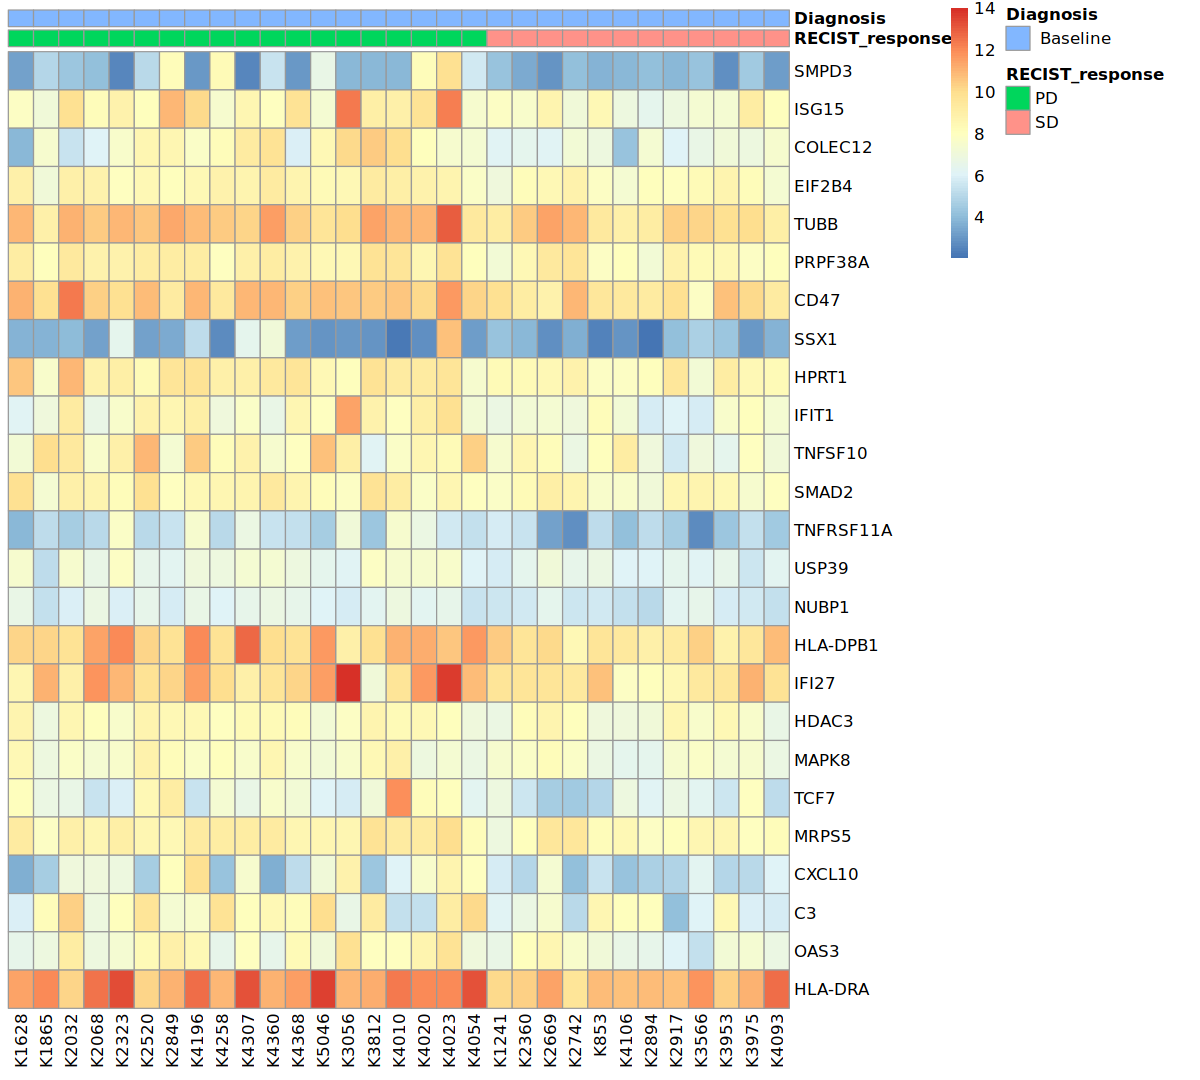

In [86]:
options(repr.plot.width=10, repr.plot.height=9)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds1)[,c('pid',"Diagnosis","RECIST_response")])



mt = assay(norm_transform_dds1)[row.names( sorted_top_de1),][1:25,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
# row_names <- row.names(mt)
# pd_columns <- row.names[grepl("B_", column_names)]
# sd_columns <- row.names[grepl("Tx_", column_names)]
sorted_df = df[order(df$RECIST_response),]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de1)[1:25]
sorted_mt = sorted_mt[,row.names(sorted_df)]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
# genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap1 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("RECIST_response","Diagnosis")], angle_col=90)

In [50]:
ggsave("10_PD_vs_SD_heatmap_baseline_only.pdf", width = 10,
  height = 9, heatmap1)


### PD vs SD within treatment

In [70]:

selected_coldata_treatment  <- subset(pData(set), Diagnosis==' Treatment')

In [71]:
selected_coldata_treatment

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group,W_1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
20230707_210462871024_K1241-Tx_09.RCC,Soft Tissue Sarcoma,Treatment,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.024920442
20230707_210462871024_K1628-Tx_10.RCC,Soft Tissue Sarcoma,Treatment,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.145375159
20230707_210462871024_K2032-Tx_11.RCC,Soft Tissue Sarcoma,Treatment,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS,0.128572415
20230707_210462871024_K2360-Tx_12.RCC,Soft Tissue Sarcoma,Treatment,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.002063674
20230707_210462871024_K853-Tx_08.RCC,Osteosarcoma,Treatment,K853,True,TI0081,SD,PFS3.Y,ADVANCED OSTEOSARCOMA,0.106523305
20230707_210462901024_K2742-Tx_01.RCC,Soft Tissue Sarcoma,Treatment,K2742,True,TI0015,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,0.289771428
20230707_210462901024_K2849-Tx_02.RCC,Osteosarcoma,Treatment,K2849,True,TI0091,PD,PFS3.N,ADVANCED OSTEOSARCOMA,-0.035836768
20230707_210462901024_K2894-Tx_03.RCC,Osteosarcoma,Treatment,K2894,True,TI0039,SD,PFS3.Y,ADVANCED OSTEOSARCOMA,0.136164014
20230707_210462901024_K2917-Tx_04.RCC,Soft Tissue Sarcoma,Treatment,K2917,True,TI0044,SD,PFS3.Y,OTHER ADVANCED SARCOMAS,-0.035979835


In [52]:
subset_count_data_treatment = counts(set)[, row.names(selected_coldata_treatment)]

In [53]:
dds2 <- DESeqDataSetFromMatrix(countData = subset_count_data_treatment,
                              colData = selected_coldata_treatment,
                              design = ~ W_1 + RECIST_response )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [54]:
de_dds2 <- DESeq(dds2)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [55]:
de_dds2 <- DESeq(dds2)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [58]:
firstC <- 'PD'
SecondC <- 'SD'
contrast<- c("RECIST_response",firstC,SecondC)
res_deseq2 <- as.data.frame(results(de_dds2))
nam2 <- paste('up_in',firstC, sep = '_')

In [59]:
res_deseq2[, nam2] <- as.logical(res_deseq2$log2FoldChange < 0)

res_deseq2$threshold <- as.logical(res_deseq2$padj < 0.05) 
res_deseq2

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,3172.59805,-0.90838230,0.6121662,-1.4838818,0.13784028,0.3774607,TRUE,FALSE
ABCB1,39.30813,0.81388693,0.4175765,1.9490728,0.05128673,0.2381950,FALSE,FALSE
ABL1,354.45185,-0.08331234,0.4235378,-0.1967058,0.84405777,0.9205729,TRUE,FALSE
ADA,58.19889,-0.05711046,0.3488386,-0.1637160,0.86995474,0.9296253,TRUE,FALSE
ADORA2A,35.59469,0.33913464,0.4904870,0.6914244,0.48929890,0.7245388,FALSE,FALSE
AICDA,13.24976,0.69653506,0.4930003,1.4128492,0.15770006,0.4065115,FALSE,FALSE
AIRE,22.59312,0.71533914,0.4038742,1.7711929,0.07652863,0.2820198,FALSE,FALSE
AKT3,592.08921,0.08296361,0.6257325,0.1325864,0.89452049,0.9384253,FALSE,FALSE
ALCAM,210.66061,0.14105480,0.6327494,0.2229236,0.82359494,0.9098538,FALSE,FALSE


In [60]:
norm_mean_w2 <- sapply(levels(de_dds2$RECIST_response), function(lvl) rowMeans( counts(de_dds2,normalized=TRUE)[,de_dds2$RECIST_response == lvl, drop=F] ) )
norm_mean_w2

,PD,SD
A2M,4302.733139,2381.50348
ABCB1,26.340508,48.38546
ABL1,369.018618,344.25512
ADA,58.444794,58.02676
ADORA2A,31.042342,38.78133
AICDA,9.748986,15.70030
AIRE,16.034275,27.18432
AKT3,588.243380,594.78129
ALCAM,222.156400,202.61355
AMBP,344.890712,749.99765


In [61]:
colnames(norm_mean_w2) <- paste('Rowmean_exp_',levels(de_dds2$RECIST_response),sep='')

res2 <- cbind(norm_mean_w2,res_deseq2)
res2

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,4302.733139,2381.50348,3172.59805,-0.90838230,0.6121662,-1.4838818,0.13784028,0.3774607,TRUE,FALSE
ABCB1,26.340508,48.38546,39.30813,0.81388693,0.4175765,1.9490728,0.05128673,0.2381950,FALSE,FALSE
ABL1,369.018618,344.25512,354.45185,-0.08331234,0.4235378,-0.1967058,0.84405777,0.9205729,TRUE,FALSE
ADA,58.444794,58.02676,58.19889,-0.05711046,0.3488386,-0.1637160,0.86995474,0.9296253,TRUE,FALSE
ADORA2A,31.042342,38.78133,35.59469,0.33913464,0.4904870,0.6914244,0.48929890,0.7245388,FALSE,FALSE
AICDA,9.748986,15.70030,13.24976,0.69653506,0.4930003,1.4128492,0.15770006,0.4065115,FALSE,FALSE
AIRE,16.034275,27.18432,22.59312,0.71533914,0.4038742,1.7711929,0.07652863,0.2820198,FALSE,FALSE
AKT3,588.243380,594.78129,592.08921,0.08296361,0.6257325,0.1325864,0.89452049,0.9384253,FALSE,FALSE
ALCAM,222.156400,202.61355,210.66061,0.14105480,0.6327494,0.2229236,0.82359494,0.9098538,FALSE,FALSE


In [62]:
top_de_genes2 = res2[row.names(res_deseq2)[which(res_deseq2$threshold)],]
top_de_genes2

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_PD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
BIRC5,196.306961,56.422715,114.022110,-1.7942465,0.4573653,-3.923005,8.745134e-05,1.683438e-02,TRUE,TRUE
CCL24,2.072611,6.946254,4.939460,1.6928448,0.5187362,3.263402,1.100832e-03,4.709117e-02,FALSE,TRUE
CD58,372.781230,156.748570,245.703195,-1.2537522,0.3452447,-3.631489,2.817912e-04,2.410880e-02,TRUE,TRUE
CDK1,297.382559,84.676962,172.261620,-1.6349962,0.4457469,-3.667992,2.444626e-04,2.352952e-02,TRUE,TRUE
CTLA4,17.831494,171.700071,108.342422,3.2630839,0.9287343,3.513474,4.422879e-04,2.953219e-02,FALSE,TRUE
DUSP4,27.286212,268.496152,169.174412,2.5107386,0.5837700,4.300904,1.701031e-05,4.365978e-03,FALSE,TRUE
GPI,899.796514,380.769464,594.486484,-1.1676867,0.3493775,-3.342192,8.311953e-04,4.000127e-02,TRUE,TRUE
KLRC2,9.086055,41.037102,27.880789,2.2757608,0.6659524,3.417302,6.324497e-04,3.691628e-02,FALSE,TRUE
MIF,1687.712085,740.648225,1130.615697,-1.1726316,0.3486339,-3.363504,7.695977e-04,3.950602e-02,TRUE,TRUE


In [64]:
write.csv(top_de_genes2, '11_DE_genes_PD_vs_SD_treatment_only.csv')

In [66]:
res_valcanoplot2 <- results(de_dds2)

In [67]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# pdf('06_Baseline_vs_Treatment_volcano_plot_matched_id.pdf')
sdvspd_volplot2 <- EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2), selectLab = row.names(top_de_genes2),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'RECIST_response PD vs SD among treatment',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)

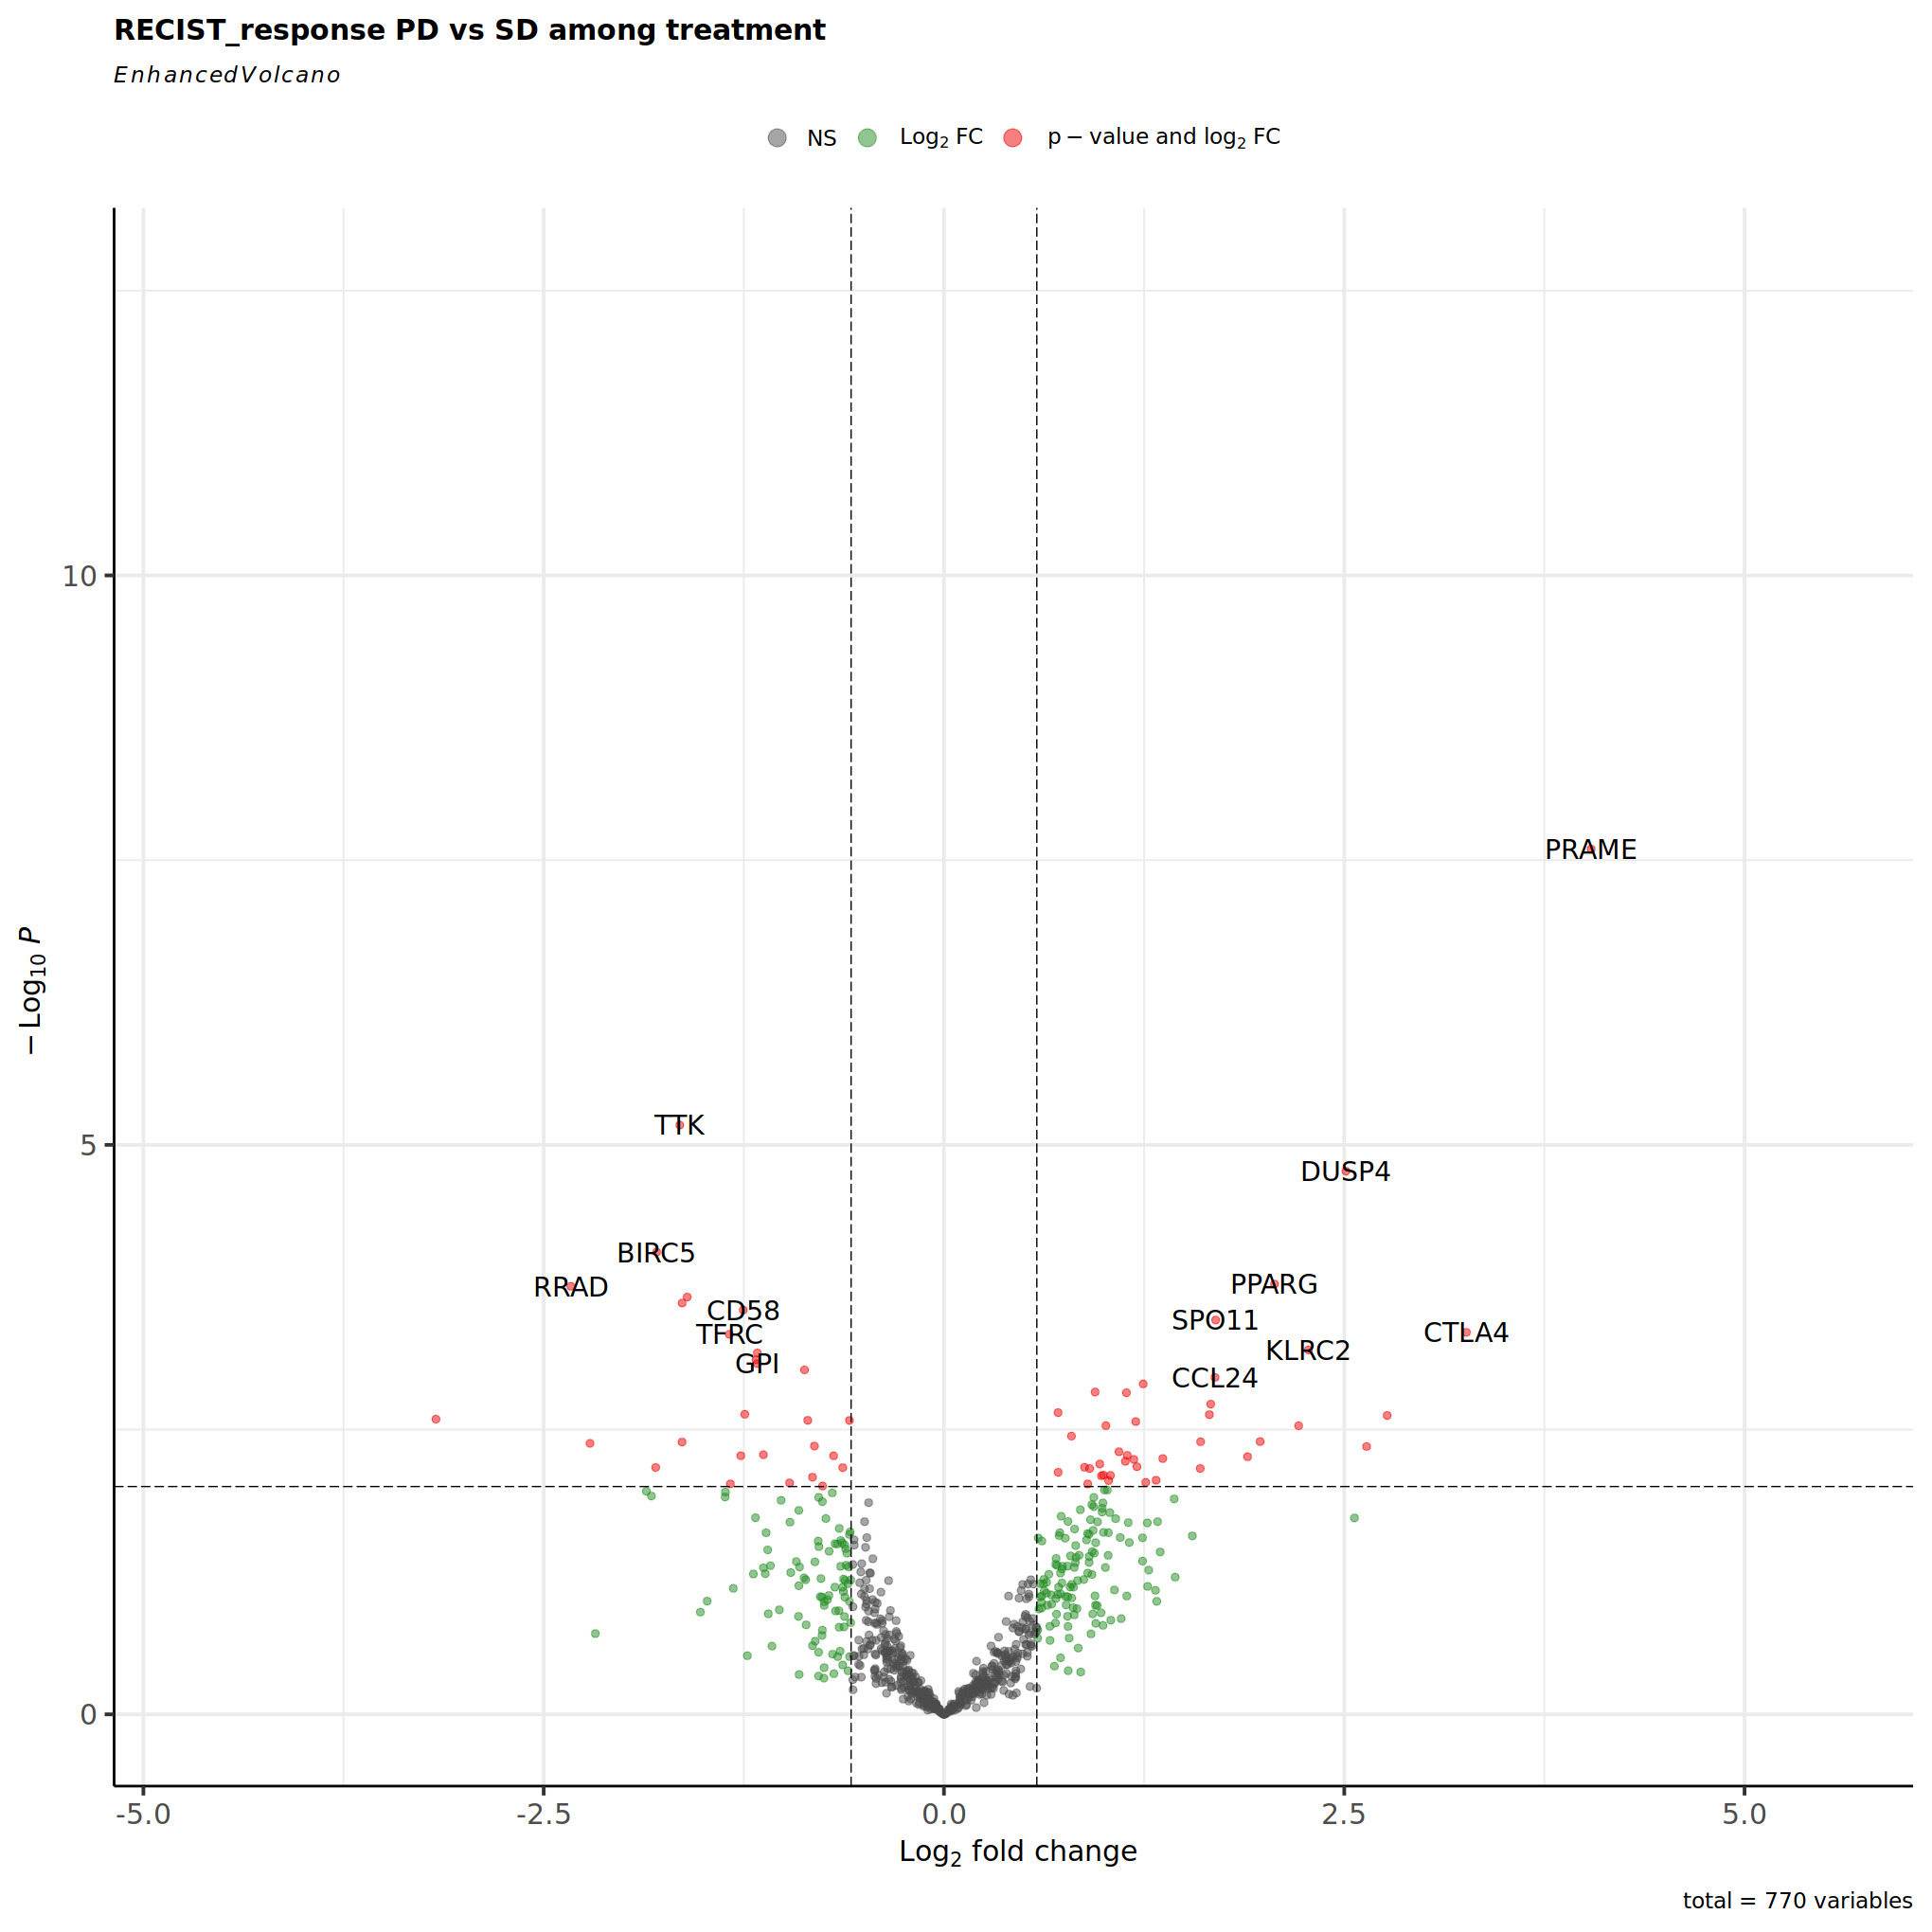

In [68]:
sdvspd_volplot2

In [72]:
ggsave("11_PD_vs_SD_volcano_plot_treatment_only.pdf", 
       width = 10,
       height = 10, sdvspd_volplot2)

In [73]:
goi6_1 = c( 'DUSP4', 'PPARG', 'SPO11','CTLA4')
goi6_1

[1] "DUSP4" "PPARG" "SPO11" "CTLA4"

In [74]:
tcounts6_1 <- t(log2((counts(de_dds2[goi6_1, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi6_1)+1):ncol(.))

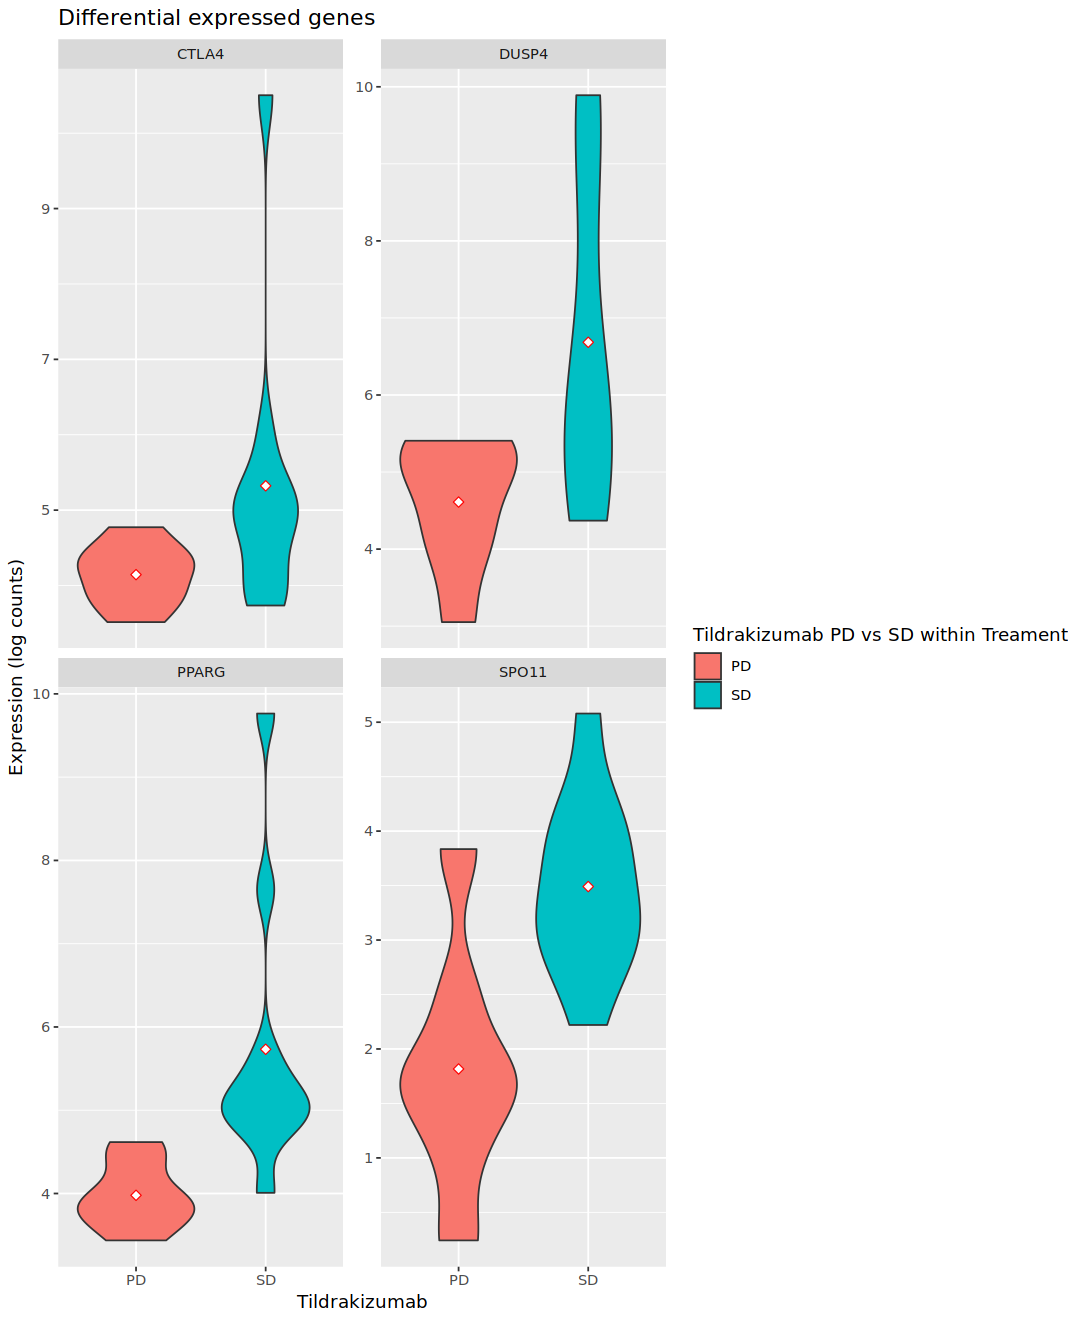

In [75]:
options(repr.plot.width=9, repr.plot.height=11)
# pdf("06_baseline_vs_treatment_violin_plot2.pdf")
sd_boxplot2 = ggplot(tcounts6_1, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab PD vs SD within Treament", 
       title="Differential expressed genes")
# dev.off()
sd_boxplot2

In [76]:
ggsave("11_PD_vs_SD_violin_plot_within_treatment.pdf", 
       width = 9,
       height = 10, sd_boxplot2)

In [77]:
norm_transform_dds2 <- normTransform(de_dds2)
norm_transform_dds2

class: DESeqTransform 
dim: 770 17 
metadata(1): version
assays(1): ''
rownames(770): A2M ABCB1 ... ZNF143 ZNF346
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(17): 20230707_210462871024_K1241-Tx_09.RCC
  20230707_210462871024_K1628-Tx_10.RCC ...
  20230707_210462901024_K4360-Tx_11.RCC
  20230707_210462901024_K4368-Tx_12.RCC
colData names(10): Conditions Diagnosis ... W_1 sizeFactor

In [78]:
sorted_top_de2 = top_de_genes2[order(top_de_genes2$up_in_PD==TRUE, top_de_genes2$padj),]


In [80]:
col_labels2 = as.data.frame(colData(de_dds2)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])
col_labels2

,pid,Diagnosis,Conditions,RECIST_response
,<chr>,<chr>,<chr>,<fct>
20230707_210462871024_K1241-Tx_09.RCC,K1241,Treatment,Soft Tissue Sarcoma,SD
20230707_210462871024_K1628-Tx_10.RCC,K1628,Treatment,Soft Tissue Sarcoma,PD
20230707_210462871024_K2032-Tx_11.RCC,K2032,Treatment,Soft Tissue Sarcoma,PD
20230707_210462871024_K2360-Tx_12.RCC,K2360,Treatment,Soft Tissue Sarcoma,SD
20230707_210462871024_K853-Tx_08.RCC,K853,Treatment,Osteosarcoma,SD
20230707_210462901024_K2742-Tx_01.RCC,K2742,Treatment,Soft Tissue Sarcoma,SD
20230707_210462901024_K2849-Tx_02.RCC,K2849,Treatment,Osteosarcoma,PD
20230707_210462901024_K2894-Tx_03.RCC,K2894,Treatment,Osteosarcoma,SD
20230707_210462901024_K2917-Tx_04.RCC,K2917,Treatment,Soft Tissue Sarcoma,SD


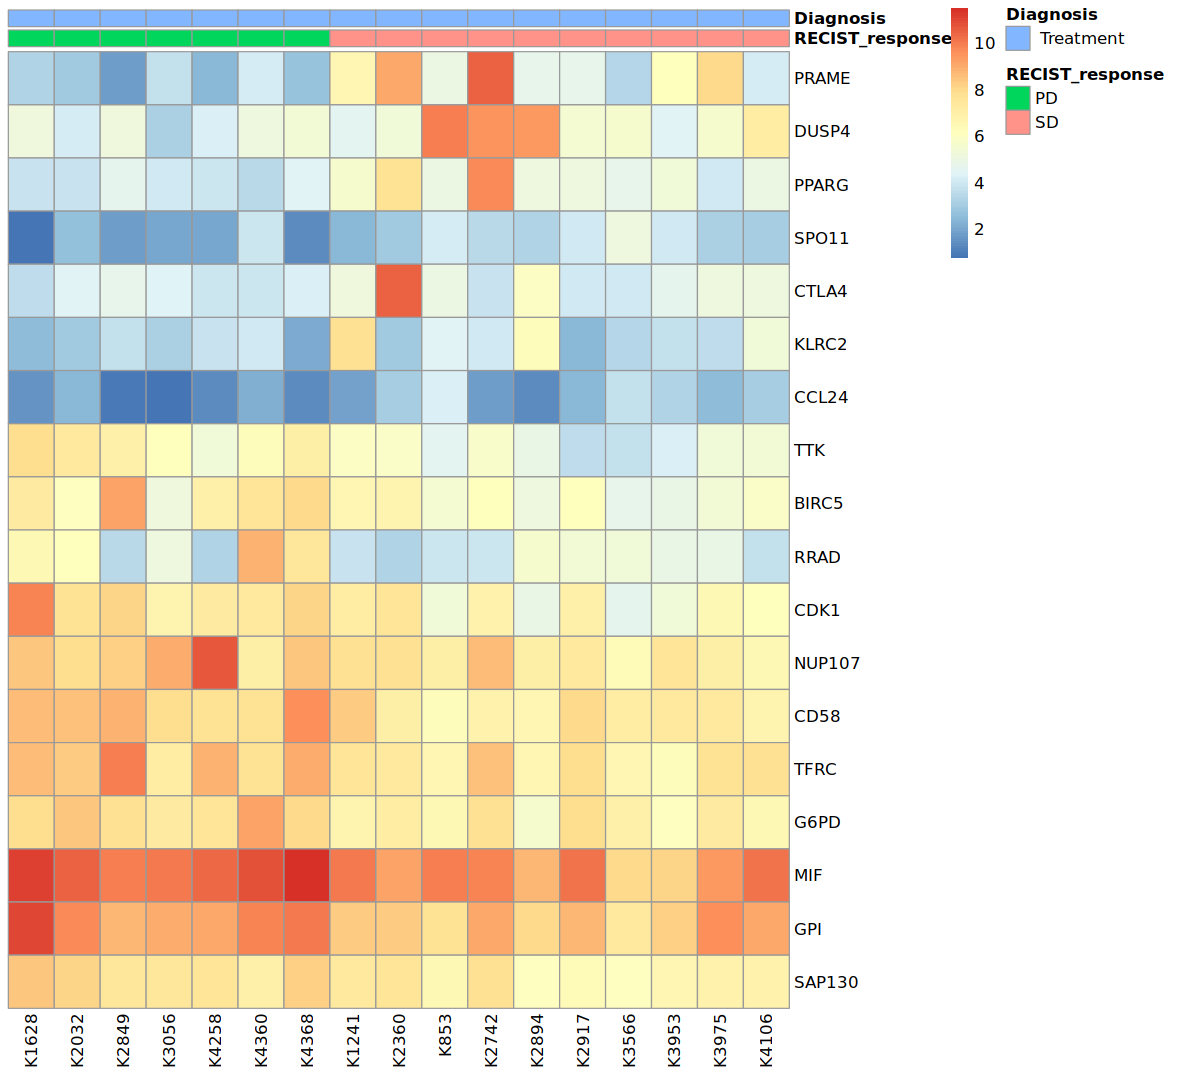

In [82]:
options(repr.plot.width=10, repr.plot.height=9)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds2)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])



mt = assay(norm_transform_dds2)[row.names( sorted_top_de2),][1:18,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
# row_names <- row.names(mt)
# pd_columns <- row.names[grepl("B_", column_names)]
# sd_columns <- row.names[grepl("Tx_", column_names)]
sorted_df = df[order(df$RECIST_response),]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de2)[1:18]
sorted_mt = sorted_mt[,row.names(sorted_df)]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
# genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap2 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("RECIST_response","Diagnosis")], angle_col=90)

In [83]:
ggsave("11_PD_vs_SD_heatmap_treatment_only.pdf", width = 10, height = 9, heatmap2)